<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 342 kB 54.5 MB/s 
     |████████████████████████████████| 4.2 MB 60.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.6 MB/s 
     |████████████████████████████████| 197 kB 71.4 MB/s 
     |████████████████████████████████| 59 kB 9.0 MB/s 
     |████████████████████████████████| 212 kB 63.2 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 136 kB 52.9 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 127 kB 57.4 MB/s 
     |████████████████████████████████| 271 kB 65.8 MB/s 
     |████████████████████████████████| 144 kB 68.2 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
from fastbook import *

#Get 100 urls of Grizzly bear images
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'https://www.lintelligencer.com/wp-content/uploads/2020/09/Alaska-Grizzly-kills-hunter-in-attack-at-national-park-Report-1068x800.jpg')

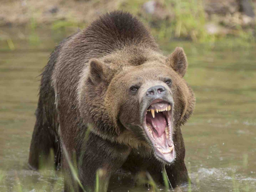

In [3]:
#Download and view image at the first url
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [4]:
#Do this for each bear type

bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
  path.mkdir()
  for b in bear_types:
    dest = (path/b)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{b} bear', max_images=100)
    download_images(dest, urls=results)

fns = get_image_files(path)
fns

(#286) [Path('bears/grizzly/00000062.jpg'),Path('bears/grizzly/00000079.jpg'),Path('bears/grizzly/00000035.jpg'),Path('bears/grizzly/00000068.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000050.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000046.jpg'),Path('bears/grizzly/00000014.jpg'),Path('bears/grizzly/00000086.jpg')...]

In [5]:
#Remove corrupt downloads
failed = verify_images(fns)
failed.map(Path.unlink)

(#4) [None,None,None,None]

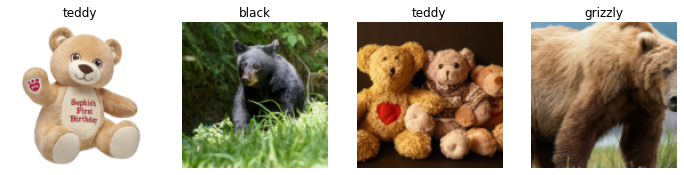

In [6]:
#Turn data into DataLoader object
#Need 4 things:
  #Data type
  #How to get list of items
  #Data labels
  #How to create validation set

#DataBlock provides template for DataLoader
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             #Independent var: Image, Dependent var: type of bear (categorical)
    get_items=get_image_files,                      #Retrieve urls like we did above
    splitter=RandomSplitter(valid_pct=.2, seed=42), #Split into training and validation set
    get_y=parent_label,                             #Tell data loader how to create label, parent_label is fastai func that returns folder name
    item_tfms=Resize(128))                          #Transform items into 128x128 squares

#Create DataLoader from DataBlock
dls = bears.dataloaders(path)   #Returns dls for training and validation sets
dls.valid.show_batch(max_n=4, nrows=1)

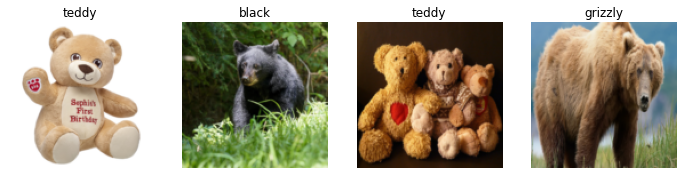

In [7]:
#by default resize crops the image
#we can tell fastai we prefer squishing
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

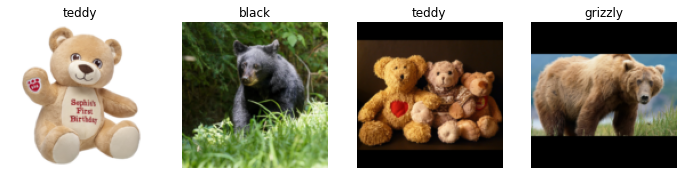

In [8]:
#or we can pad images with zeros (black)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

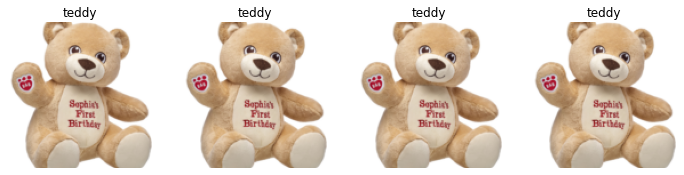

In [9]:
#Standard practice is to select random part of the image and crop that section
#using a different piece of the image on each epoch
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True) #unique=True will show different versions of the same image

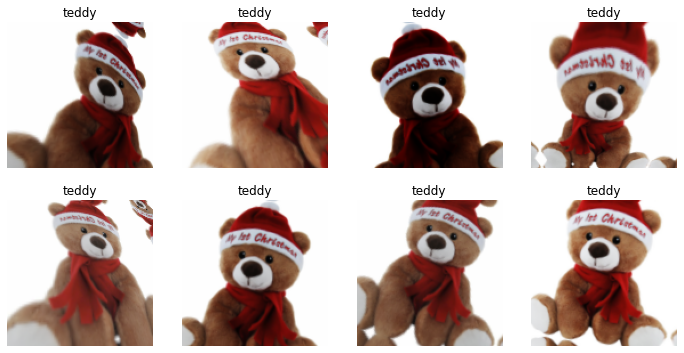

In [10]:
#Data Augmentation
#Simply creating random variations of the same data
#Common techniques: rotation, flipping, perspective warping, brightness and contrast changes

#Exaggerated example
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) #aug_transforms is a standard set of common transforms
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [11]:
#Training our model

#Reset our dataloader from examples above
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

#Create our learner
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.451113,0.300786,0.107143,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.388592,0.110560,0.017857,00:21
1,0.249689,0.072585,0.017857,00:21
2,0.182345,0.059983,0.017857,00:21
3,0.148153,0.059295,0.017857,00:21


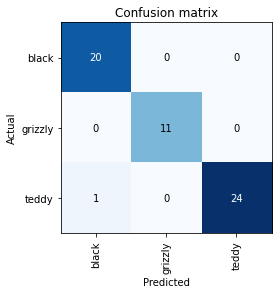

In [12]:
#Analyze Performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

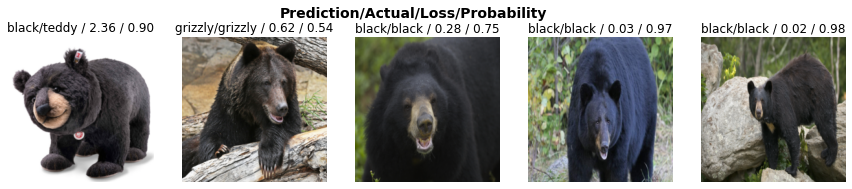

In [13]:
#View items with highest loss
interp.plot_top_losses(5, nrows=1)

In [14]:
#Export our model
learn.export()

In [15]:
#Check file exsits
path = Path()
path.ls(file_exts='.pkl') #This is the file needed wherever you export to

(#1) [Path('export.pkl')]

In [16]:
#Not practical but we will test loading into same notebook

learn_inf = load_learner(path/'export.pkl')
learn_inf.predict(fns[3])

('grizzly', TensorBase(1), TensorBase([2.5979e-07, 1.0000e+00, 1.1133e-08]))

In [17]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

Below we will set up a simple gui and use viola to make a web application

In [19]:
#Upload image button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [21]:
#Store the image
img = PILImage.create(btn_upload.data[-1])
#Display the image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [22]:
#Get our prediction
pred,pred_idx,probs = learn_inf.predict(img)
#Display prediction
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction: {pred};  Probability: {probs[pred_idx]:.04f}"

In [23]:
#Do Work Button
btn_run = widgets.Button(description="Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [24]:
#Click function
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f"Prediction: {pred};  Probability: {probs[pred_idx]:.04f}"
#Bind button to func
btn_run.on_click(on_click_classify)

In [26]:
from fastai.vision.widgets import *
#Create GUI
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])